In [524]:
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima, ADFTest
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [336]:
df = pd.read_csv('SERIE_TEMPORAL.csv')

In [282]:
df.dtypes

NU_ANO_CENSO    int64
QT_MAT_BAS      int64
dtype: object

In [534]:
df.head(10)

,QT_MAT_BAS
NU_ANO_CENSO,
2014,49771371
2015,48796512
2016,48817479
2017,48608093
2018,48455867
2019,47874246
2020,47295294
2021,46668401
2022,47382074


In [53]:
df.isnull().sum()

NU_ANO_CENSO    0
QT_MAT_BAS      0
dtype: int64

In [337]:
df['NU_ANO_CENSO'] = pd.to_datetime(df['NU_ANO_CENSO'], format='%Y')

In [338]:
df.set_index('NU_ANO_CENSO', inplace=True)

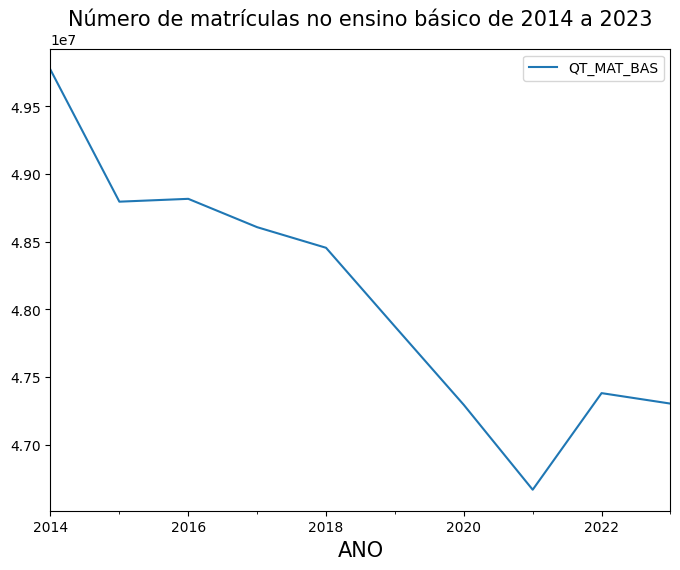

In [547]:
df['QT_MAT_BAS'].plot(figsize=(8,6), legend=True)
plt.xlabel('ANO', size=15)
plt.title('Número de matrículas no ensino básico de 2014 a 2023', size=15);

In [574]:
treino = df['QT_MAT_BAS'].loc[:'2020']
teste = df['QT_MAT_BAS'].loc['2021':]
print(treino.shape[0])
print(teste.shape[0])

7
3


In [575]:
teste

NU_ANO_CENSO
2021    46668401
2022    47382074
2023    47304632
Freq: Y-DEC, Name: QT_MAT_BAS, dtype: int64

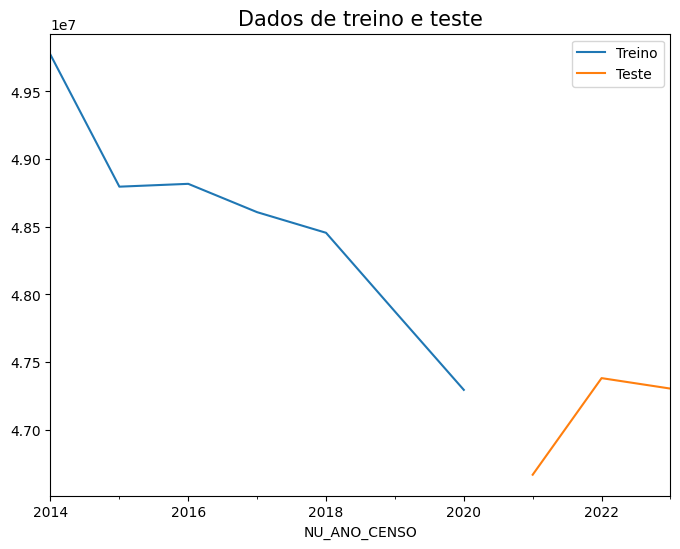

In [576]:
fig, ax=plt.subplots(figsize=(8, 6))
treino.plot(ax=ax, label='train')
teste.plot(ax=ax, label='test')
plt.legend(['Treino','Teste','previsão'])
plt.title('Dados de treino e teste', size=15);
plt.show()

In [398]:
treino = pd.DataFrame(treino)
teste = pd.DataFrame(teste)

DatetimeIndex(['2014-01-01', '2015-01-01', '2016-01-01', '2017-01-01',
               '2018-01-01', '2019-01-01', '2020-01-01'],
              dtype='datetime64[ns]', name='NU_ANO_CENSO', freq=None)

In [577]:
model = auto_arima(
    treino,
    seasonal=False,
    suppress_warnings=True,
    stepwise=True
)

In [450]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                    7
Model:               SARIMAX(1, 0, 2)   Log Likelihood                -106.985
Date:                Fri, 01 Nov 2024   AIC                            221.970
Time:                        13:47:59   BIC                            221.754
Sample:                    01-01-2014   HQIC                           219.296
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9997      0.012     83.944      0.000       0.976       1.023
ma.L1          0.3713      1.786      0.208      0.835      -3.129       3.872
ma.L2          0.2948      2.750      0.107      0.915      -5.095       5.685
sigma2      5.228e+11    1.8e-12    2.9e+23      0.000    5.23e+11    5.23e+11
===================================================================================
Ljung-Box (L1) (Q):                   3.00   Jarque-Bera (JB):                 0.33
Prob(Q):                              0.08   Prob(JB):                         0.85
Heteroskedasticity (H):               0.24   Skew:                             0.34
Prob(H) (two-sided):                  0.39   Kurtosis:                         2.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.58e+41. Standard errors may be unstable.
"""

In [451]:
print(model.aic())
print(model.bic())

221.97023776627105
221.75387836249232


In [556]:
teste = df['QT_MAT_BAS'].loc['2020':]

In [579]:
model.fit(treino)

ARIMA(order=(1, 0, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [578]:
teste

NU_ANO_CENSO
2021    46668401
2022    47382074
2023    47304632
Freq: Y-DEC, Name: QT_MAT_BAS, dtype: int64

In [580]:
periodos = len(teste) + 1
periodos

4

In [581]:
periodos = len(teste) + 1
forecast = model.predict(n_periods=periodos)

In [582]:
forecast

2021    4.702336e+07
2022    4.691117e+07
2023    4.689680e+07
2024    4.688243e+07
Freq: Y-DEC, dtype: float64

In [460]:
# forecast = pd.DataFrame(forecast,
#                       index=forecast.index,
#                       columns=['previsao_modelo_1'])

In [561]:
forecast

2021    4.750172e+07
2022    4.785521e+07
2023    4.821845e+07
2024    4.838231e+07
Freq: Y-DEC, Name: predicted_mean, dtype: float64


<Figure size 1600x500 with 0 Axes>

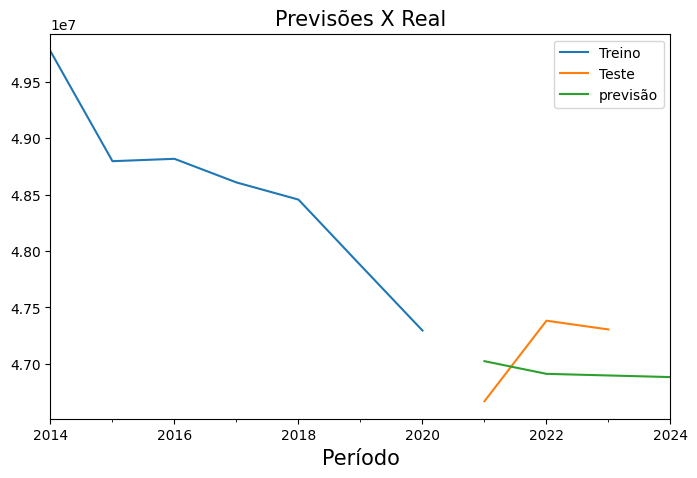

In [583]:
plt.figure(figsize=(16,5))
pd.concat([treino, teste, forecast],axis=1).plot(figsize=(8,5))
plt.xlabel('')
plt.title('Previsões X Real',size=15)
plt.xlabel("Período", size=15)
plt.legend(['Treino','Teste','previsão'])
plt.show()

In [588]:
forecast[:-1]

2021    4.702336e+07
2022    4.691117e+07
2023    4.689680e+07
Freq: Y-DEC, dtype: float64

In [590]:
# Calcular o erro absoluto médio (MAE)
mae = mean_absolute_error(teste, forecast[:-1])

# Calcular o erro quadrático médio (MSE)
mse = mean_squared_error(teste, forecast[:-1])

# Calcular a raiz do erro quadrático médio (RMSE)
rmse = np.sqrt(mse)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)

MAE: 411235.37073826295
MSE: 171360769936.4692
RMSE: 413957.44942743715


In [563]:
df.index = pd.DatetimeIndex(df.index).to_period('Y')

TypeError: Passing PeriodDtype data is invalid. Use `data.to_timestamp()` instead

In [487]:
treino.index = pd.DatetimeIndex(treino.index).to_period('Y')


In [510]:
# ARIMA
p, d, q = 1, 0, 2
arima = ARIMA(treino, order=(p, d, q))

In [511]:
model_fit = arima.fit()

C:\Users\lino.pereira\PycharmProjects\censo_escolar\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [512]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             QT_MAT_BAS   No. Observations:                    7
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -103.161
Date:                Fri, 01 Nov 2024   AIC                            216.321
Time:                        14:09:32   BIC                            216.051
Sample:                    12-31-2014   HQIC                           212.978
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.852e+07   9.96e+05     48.729      0.000    4.66e+07    5.05e+07
ar.L1          0.4511      2.585      0.175      0.861      -4.615       5.517
ma.L1          0.4770      2.294      0.208      0.835      -4.019       4.973
ma.L2          0.3306      3.263      0.101      0.919      -6.065       6.726
sigma2      5.228e+11      0.630    8.3e+11      0.000    5.23e+11    5.23e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.66   Jarque-Bera (JB):                 0.69
Prob(Q):                              0.42   Prob(JB):                         0.71
Heteroskedasticity (H):               0.63   Skew:                             0.62
Prob(H) (two-sided):                  0.77   Kurtosis:                         2.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.93e+27. Standard errors may be unstable.
"""

In [522]:
forecast_steps = 4
arima_forecast = model_fit.forecast(steps=forecast_steps)

In [527]:
mae = mean_absolute_error(teste, arima_forecast)

In [531]:
# Calcular o erro quadrático médio (MSE)
mse = mean_squared_error(teste, arima_forecast)

# Calcular a raiz do erro quadrático médio (RMSE)
rmse = np.sqrt(mse)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)


MAE: 826820.9127504155
MSE: 828008939029.7966
RMSE: 909949.9651243449


# Até aqui

In [ ]:
# Ate aqui

In [ ]:
plot_acf(df['QT_MAT_BAS'], lags=5)
plot_pacf(df['QT_MAT_BAS'], lags=5)
plt.show()

In [ ]:
decomposicao_multi = seasonal_decompose(df['QT_MAT_BAS'], model='additive', period=2)
decomposicao_multi.plot()
plt.show()

In [61]:
# Hipótese Nula: Os dados não são estacionários
# Hipótese alternativa: Os dados são estacionários
def adftest(series, plots=True):
    out = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {out[0]:.2f}')
    print(f'p-value: {out[1]:.3f}')
    print(f"Critical Values: {[f'{k}: {r:.2f}' for r,k in zip(out[4].values(), out[4].keys())]}\n")
    
    if plots:
        # Compute rolling statistics
        rolmean = series.rolling(window=12).mean()
        rolstd = series.rolling(window=12).std()

        # Plot rolling statistics:
        plt.figure(figsize=(14, 4))
        plt.plot(series, color='tab:blue',label='Original')
        plt.plot(rolmean, color='tab:red', label='Rolling Mean')
        plt.plot(rolstd, color='black', label = 'Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean and Standard Deviation')
        plt.grid()

In [62]:
def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    return result[1] <= 0.05

In [63]:
def calcula_ordem_diferenciacao(series):
    d = 0
    while not adf_test(series):
        d += 1
        serie = series.diff().dropna()
        plt.figure(figsize=(12, 6))
        plt.plot(serie)
        plt.title(f'Série Diferenciada {d} vez(es)')
        plt.show()
    print(f'A série se tornou estacionária após {d} diferenciações.')

In [ ]:
#calcula_ordem_diferenciacao(df.QT_MAT_BAS)

In [ ]:
adftest(df.QT_MAT_BAS, plots=True)

In [57]:
sazonalidade = 2
df['sazonal_diff'] = df.QT_MAT_BAS.diff(sazonalidade)

In [58]:
df.dropna(inplace=True)

In [ ]:
decomposicao_multi = seasonal_decompose(df['sazonal_diff'], model='additive', period=sazonalidade)
decomposicao_multi.plot()
plt.show()

In [ ]:
adftest(df.sazonal_diff, plots=True)

In [323]:
forecast

,previsao_modelo_1
NU_ANO_CENSO,
2014-01-01,NaN
2015-01-01,NaN
2016-01-01,NaN
2017-01-01,NaN
2018-01-01,NaN
2019-01-01,NaN
2020-01-01,NaN
2021-01-01,4.671629e+07
2022-01-01,4.613729e+07


In [ ]:
plt.figure(figsize=(20,5))
pd.concat([teste, forecast],axis=1).plot(figsize=(20,5))
plt.xlabel('')
plt.title('Previsões X Real',size=15)
plt.xlabel("Período", size=15)
plt.legend(['Valor real','previsão'])
plt.show()

In [ ]:
plt.plot(treino, color='red')
plt.plot(forecast,color='green')
plt.legend(['Treino','Valores preditos']);

In [65]:
p, d, q = 1, 2, 0

In [247]:
model = ARIMA(df, order=(p, d, q))

In [249]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             QT_MAT_BAS   No. Observations:                   10
Model:                 ARIMA(1, 2, 0)   Log Likelihood                -117.428
Date:                Fri, 01 Nov 2024   AIC                            238.856
Time:                        12:33:53   BIC                            239.015
Sample:                    12-31-2014   HQIC                           237.785
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0201      0.171     -0.118      0.906      -0.356       0.316
sigma2      2.894e+11   7.51e-14   3.85e+24      0.000    2.89e+11    2.89e+11
Ljung-Box (L1) (Q):                   2.05   Jarque-

In [250]:
forecast_steps = 2
forecast = model_fit.forecast(steps=forecast_steps)

TypeError: float() argument must be a string or a real number, not 'Period'

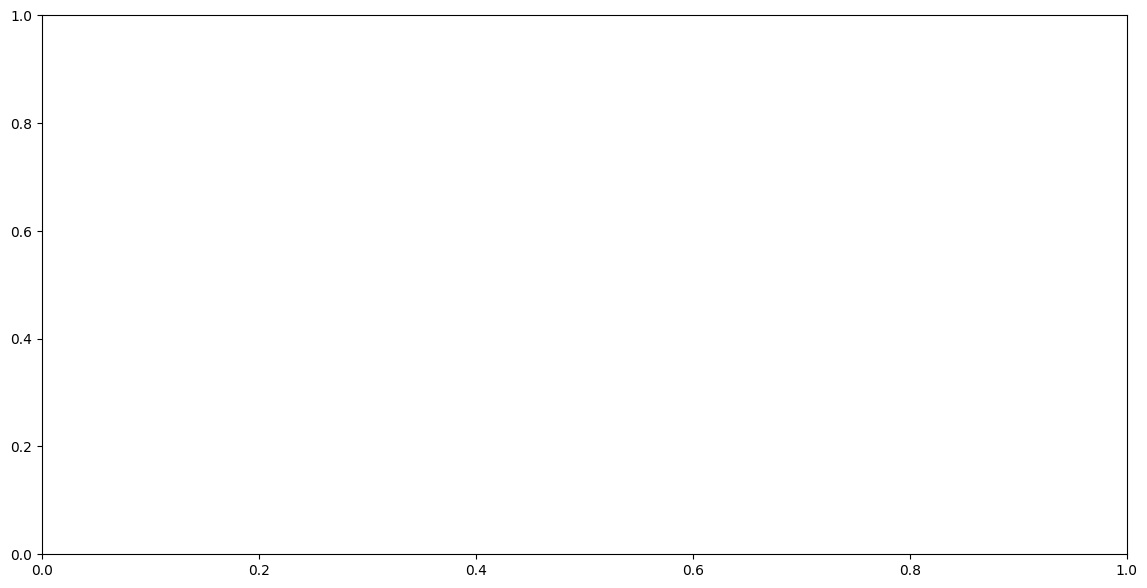

In [254]:

plt.figure(figsize=(14, 7))
plt.plot(df.index, df.QT_MAT_BAS, label='Dados Originais')
plt.plot(forecast.index, forecast, label='Previsão', color='red')
plt.title('Previsão de Nascimentos')
plt.xlabel('Data')
plt.ylabel('Número de Nascimentos')
plt.legend()
plt.show()

In [190]:
forecast

2024    4.724312e+07
2025    4.718129e+07
Freq: Y-DEC, Name: predicted_mean, dtype: float64

In [162]:
teste['2024'] = forecast.iloc[1]

In [163]:
teste

NU_ANO_CENSO
2020    4.729529e+07
2021    4.666840e+07
2022    4.738207e+07
2023    4.730463e+07
2024    4.718129e+07
Freq: Y-DEC, Name: QT_MAT_BAS, dtype: float64

<Figure size 2000x500 with 0 Axes>

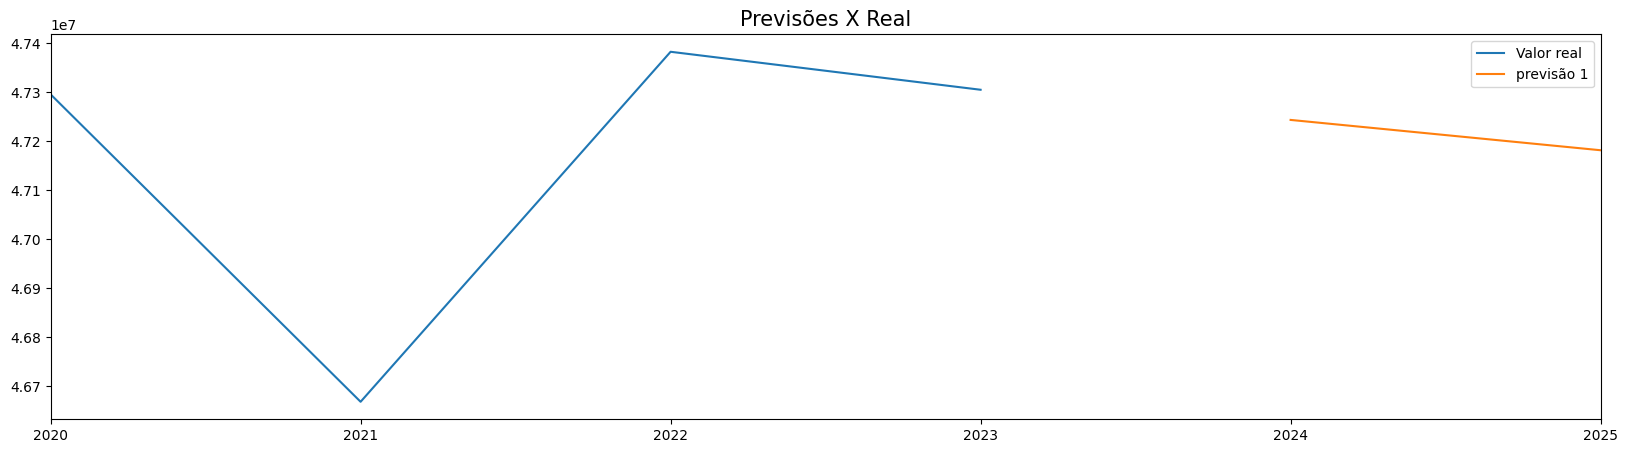

In [191]:
plt.figure(figsize=(20,5))
pd.concat([teste, forecast],axis=1).plot(figsize=(20,5))
plt.xlabel('')
plt.title('Previsões X Real',size=15)
plt.legend(['Valor real','previsão 1'])
plt.show();